In [1]:
from keras.datasets import mnist
from keras.utils import np_utils

(X_train0, y_train0), (X_test0, y_test0) = mnist.load_data()

X_train = X_train0.reshape(60000, 784).astype('float32') / 255.0
X_test = X_test0.reshape(10000, 784).astype('float32') / 255.0
Y_train = np_utils.to_categorical(y_train0, 10)
Y_test = np_utils.to_categorical(y_test0, 10)

/home/mk/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD

In [3]:
model1 = Sequential()
model1.add(Dense(15, input_dim=784, activation="sigmoid"))
model1.add(Dense(10, activation="sigmoid"))
model1.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=["accuracy"])

In [4]:
model2 = Sequential()
model2.add(Dense(15, input_dim=784, activation="sigmoid"))
model2.add(Dense(15, activation="sigmoid"))
model2.add(Dense(10, activation="sigmoid"))
model2.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=["accuracy"])

In [5]:
model3 = Sequential()
model3.add(Dense(15, input_dim=784, activation="sigmoid"))
model3.add(Dense(15, activation="sigmoid"))
model3.add(Dense(15, activation="sigmoid"))
model3.add(Dense(10, activation="sigmoid"))
model3.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=["accuracy"])

In [6]:
model4 = Sequential()
model4.add(Dense(15, input_dim=784, activation="sigmoid"))
model4.add(Dense(15, activation="sigmoid"))
model4.add(Dense(15, activation="sigmoid"))
model4.add(Dense(15, activation="sigmoid"))
model4.add(Dense(10, activation="sigmoid"))
model4.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=["accuracy"])

콜백 오브젝트

정해진 시점에 메소드 실행

In [7]:
from keras.callbacks import Callback

class WeightHistory(Callback):
    
    def __init__(self, model, num_epoch):
        super().__init__()
        self.model = model
        self.num_hidden = len(model.layers) - 1
        self.weight_old = [self.model.layers[i].get_weights()[0] for i in range(self.num_hidden)]
        self.weight = [0.0 for i in range(self.num_hidden)]
        self.weight_change = np.zeros((self.num_hidden, num_epoch))
        
    def on_epoch_end(self, epoch, logs={}):
        for i in range(self.num_hidden):
            self.weight[i] = self.model.layers[i].get_weights()[0]
            self.weight_change[i, epoch] = np.abs((self.weight[i] - self.weight_old[i]).mean())
            self.weight_old[i] = self.weight[i]
            

In [8]:
num_epoch = 500

In [ ]:
%%time
callback1 = WeightHistory(model1, num_epoch)
hist1 = model1.fit(X_train, Y_train, epochs=num_epoch, 
                   batch_size=100, callbacks=[callback1], verbose=0)

레이어가 많으면 가중치가 다같이 움직이지는 않는다.

뒷단보다 앞단 레이어가 잘 안움직인다.
- 그레디언트가 작다
- gradient banishing problem

why?
 - backpropagation 하면서 시그모이드 도함수를 타고 오는데, 올수록 $\delta$값이 작아짐
 - w, x, b가 커지면 a가 커짐 -> 얘들을 넣을때 작게 넣어야함
 - mu (learning rate도 작게)

## 근본적으로 막는 방법

- 오차(목적) 함수 개선: cross-entropy cost function
- Activation 함수 선택: hyper-tangent and ReLu
- 가중치 초기값: weight initialization
- 정규화: regularization
- Softmax 출력

classification -> cross-entropy 

activation함수가 오차함수 미분에 들어가지 않는다.
- +오차가 크면 스탭사이즈가 크고, 적으면 스탭사이즈가 작아짐

regression -> mean-square-error

### Keras

`model0.compile(optimizer=SGD(lr=0.2), loss='mean_squared_error', metrics=["accuracy"])`

loss를 바꿔주면 된다.

In [9]:
np.random.seed(0)
model1 = Sequential()
model1.add(Dense(15, input_dim=784, activation="sigmoid"))
model1.add(Dense(10, activation="sigmoid"))
model1.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=["accuracy"])

In [11]:
%%time
hist1 = model1.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min 58s, sys: 5.17 s, total: 2min 3s
Wall time: 1min 13s


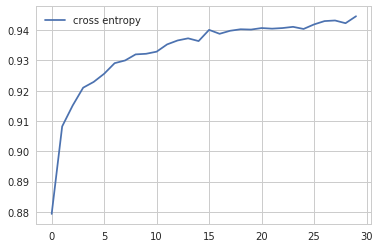

In [13]:
%matplotlib inline
plt.plot(hist0.history['val_acc'], ls=":", label="mean squared error")
plt.plot(hist1.history['val_acc'], label="cross entropy")
plt.legend()
plt.show()

앞단  activate 함수
- Sigmoid -> ReLu (CNN 처럼 모델이 복잡한 경우만)

단점, a가 음수이면 기울기가 0 -> Leaky ReLu로 보완

In [14]:
np.random.seed(0)
model3 = Sequential()
model3.add(Dense(15, input_dim=784, activation="relu"))
model3.add(Dense(10, activation="sigmoid"))
model3.compile(optimizer=SGD(lr=0.2), loss='categorical_crossentropy', metrics=["accuracy"])

In [15]:
%%time
hist3 = model3.fit(X_train, Y_train, epochs=30, batch_size=100, validation_data=(X_test, Y_test), verbose=0)

CPU times: user 1min 57s, sys: 5.22 s, total: 2min 3s
Wall time: 1min 15s


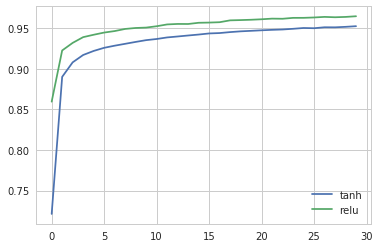

In [17]:
# plt.plot(hist1.history['acc'], label="logistic")
plt.plot(hist1.history['acc'], label="tanh")
plt.plot(hist3.history['acc'], label="relu")
plt.legend()
plt.show()

Relu 성능을 높이는법 -> 모델을 복잡하게 ( 레이어, 노드 확장 가능 )

## 가중치 초기화
반드시 넣어주어야 함

kernel_initializer="nomal" -> "glorot_uniform"

In [ ]:
np.random.seed(0)
model4 = Sequential()
model4.add(Dense(100, kernel_initializer="normal", activation="sigmoid", input_dim=784))
model4.add(Dense(10, kernel_initializer="normal", activation="sigmoid"))
model4.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

In [ ]:
np.random.seed(0)
model5 = Sequential()
model5.add(Dense(100, input_dim=784, activation="sigmoid", kernel_initializer="glorot_uniform"))
model5.add(Dense(10, activation="sigmoid", kernel_initializer="glorot_uniform"))
model5.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

## 과최적화 문제
상황에 따라서, 하지만 dropout 은 거의 필수

- 정규화 (L1, L2)
- Dropout 정규화

In [ ]:
from keras.layers import Dropout

np.random.seed(0)
model8 = Sequential()
model8.add(Dense(30, input_dim=784, activation="sigmoid"))
model8.add(Dropout(0.5))
model8.add(Dense(10, activation="sigmoid"))
model8.compile(optimizer=SGD(lr=0.5), loss='categorical_crossentropy', metrics=["accuracy"])

---

## 소프트맥스 출력
출력값이 확률이 아니기 때문에(합이 1이 아님), 소프트 맥스를 이용하여 총합이 1이 되게 변환
- 확률은 아니지만 확률처럼 보임
- 주의/ L파라미터가 너무 크면 왜곡이 될 수 있음
- 관례처럼 사용함

마지막 노드의 activation함수를 `softmax`로 사용

In [ ]:
np.random.seed(0)
model9 = Sequential()
model9.add(Dense(15, input_dim=784, activation="sigmoid", kernel_initializer="glorot_uniform"))
model9.add(Dense(10, activation="softmax", kernel_initializer="glorot_uniform"))
model9.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=["accuracy"])

In [11]:
%%time
from keras.datasets import mnist
(X_train0, y_train0), (X_test0, y_test0) = mnist.load_data()

CPU times: user 454 ms, sys: 27.4 ms, total: 482 ms
Wall time: 489 ms


In [13]:
X_train0.shape

(60000, 28, 28)

---

In [1]:
from sklearn.datasets import fetch_olivetti_faces
from sklearn.model_selection import train_test_split

olivetti = fetch_olivetti_faces()

X_train0, X_test0 = train_test_split(olivetti.data, test_size = .2, random_state=0)
y_train0, y_test0= train_test_split(olivetti.target, test_size = .2, random_state=0)

In [2]:
olivetti.data.shape

(400, 4096)

In [3]:
print(X_train0.shape, X_train0.dtype)
print(y_train0.shape, y_train0.dtype)
print(X_test0.shape, X_test0.dtype)
print(y_test0.shape, y_test0.dtype)

(320, 4096) float32
(320,) int64
(80, 4096) float32
(80,) int64


In [4]:
X_train = X_train0.astype('float32') / 255.0
X_test = X_test0.astype('float32') / 255.0

In [5]:
y_train0[:5]

array([33,  6,  5, 10, 30])

In [8]:
from keras.utils import np_utils

Y_train = np_utils.to_categorical(y_train0, 40)
Y_test = np_utils.to_categorical(y_test0, 40)
Y_train[:5]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0.]])

In [12]:
Y_test.shape

(80, 40)

In [57]:
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import SGD
from keras.layers import Dropout
import numpy as np
from keras import regularizers

In [61]:
np.random.seed(0)

model = Sequential()
model.add(Dense(1000, input_dim=4096, kernel_initializer="glorot_uniform", 
                kernel_regularizer=regularizers.l2(0.0001), activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1000, kernel_initializer="glorot_uniform", activation="relu", 
                  kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(1000,  kernel_initializer="glorot_uniform", activation="relu", 
                  kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dropout(0.2))
model.add(Dense(40, kernel_initializer="glorot_uniform", activation="softmax"))
model.compile(optimizer=SGD(lr=0.1), loss='categorical_crossentropy', metrics=["accuracy"])

In [62]:
%%time
hist = model.fit(X_train, Y_train, 
                 epochs=100, batch_size=100, 
                 validation_data=(X_test, Y_test), 
                 verbose=2)

Train on 320 samples, validate on 80 samples
Epoch 1/100
 - 3s - loss: 4.0502 - acc: 0.0281 - val_loss: 4.0519 - val_acc: 0.0125
Epoch 2/100
 - 1s - loss: 4.0496 - acc: 0.0187 - val_loss: 4.0537 - val_acc: 0.0250
Epoch 3/100
 - 1s - loss: 4.0492 - acc: 0.0250 - val_loss: 4.0559 - val_acc: 0.0125
Epoch 4/100
 - 1s - loss: 4.0483 - acc: 0.0281 - val_loss: 4.0586 - val_acc: 0.0000e+00
Epoch 5/100
 - 1s - loss: 4.0478 - acc: 0.0250 - val_loss: 4.0604 - val_acc: 0.0125
Epoch 6/100
 - 1s - loss: 4.0475 - acc: 0.0281 - val_loss: 4.0633 - val_acc: 0.0125
Epoch 7/100
 - 1s - loss: 4.0465 - acc: 0.0250 - val_loss: 4.0652 - val_acc: 0.0125
Epoch 8/100
 - 1s - loss: 4.0462 - acc: 0.0281 - val_loss: 4.0672 - val_acc: 0.0125
Epoch 9/100
 - 1s - loss: 4.0456 - acc: 0.0250 - val_loss: 4.0688 - val_acc: 0.0125
Epoch 10/100
 - 2s - loss: 4.0453 - acc: 0.0187 - val_loss: 4.0715 - val_acc: 0.0125
Epoch 11/100
 - 2s - loss: 4.0445 - acc: 0.0281 - val_loss: 4.0730 - val_acc: 0.0125
Epoch 12/100
 - 2s - loss

Epoch 94/100
 - 1s - loss: 4.0309 - acc: 0.0156 - val_loss: 4.1656 - val_acc: 0.0000e+00
Epoch 95/100
 - 2s - loss: 4.0308 - acc: 0.0312 - val_loss: 4.1649 - val_acc: 0.0000e+00
Epoch 96/100
 - 1s - loss: 4.0287 - acc: 0.0312 - val_loss: 4.1639 - val_acc: 0.0000e+00
Epoch 97/100
 - 1s - loss: 4.0321 - acc: 0.0312 - val_loss: 4.1636 - val_acc: 0.0000e+00
Epoch 98/100
 - 1s - loss: 4.0306 - acc: 0.0344 - val_loss: 4.1647 - val_acc: 0.0000e+00
Epoch 99/100
 - 1s - loss: 4.0290 - acc: 0.0375 - val_loss: 4.1652 - val_acc: 0.0000e+00
Epoch 100/100
 - 1s - loss: 4.0317 - acc: 0.0219 - val_loss: 4.1656 - val_acc: 0.0000e+00
CPU times: user 7min 24s, sys: 39.6 s, total: 8min 4s
Wall time: 2min 24s


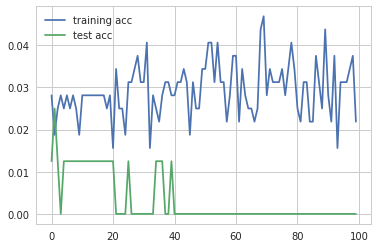

In [63]:
%matplotlib inline
plt.plot(hist.history['acc'], label="training acc")
plt.plot(hist.history['val_acc'], label="test acc")
plt.legend()
plt.show()
